In [ ]:
# downloading data
import requests
from urllib.parse import urlencode

def download_file(file_id: str, file_name: str) -> None:
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = f'https://yadi.sk/d/{file_id}'  # Сюда вписываете вашу ссылку

    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    with open(file_name, 'wb') as f:   # Здесь укажите нужный путь к файлу
        f.write(download_response.content)

download_file('Y9m6dqEAGkO2-A', 'vk-made-ocr.zip')
!unzip vk-made-ocr.zip

Archive:  vk-made-ocr.zip
  inflating: sample_submission.csv   
  inflating: test/test/1.jpg         
  inflating: test/test/10.jpg        
  inflating: test/test/100.jpg       
  inflating: test/test/1000.jpg      
  inflating: test/test/10000.jpg     
  inflating: test/test/10001.jpg     
  inflating: test/test/10002.jpg     
  inflating: test/test/10003.jpg     
  inflating: test/test/10004.jpg     
  inflating: test/test/10005.jpg     
  inflating: test/test/10006.jpg     
  inflating: test/test/10007.jpg     
  inflating: test/test/10008.jpg     
  inflating: test/test/10009.jpg     
  inflating: test/test/1001.jpg      
  inflating: test/test/10010.jpg     
  inflating: test/test/10011.jpg     
  inflating: test/test/10012.jpg     
  inflating: test/test/10013.jpg     
  inflating: test/test/10014.jpg     
  inflating: test/test/10015.jpg     
  inflating: test/test/10016.jpg     
  inflating: test/test/10017.jpg     
  inflating: test/test/10018.jpg     
  inflating: test/test/1

In [2]:
import numpy as np
import pandas as pd
import torch
import os
from PIL import Image
from matplotlib import pyplot as plt
from collections import Counter
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear
from torch.nn.functional import ctc_loss, log_softmax
from torchvision import models
from torchaudio.functional import edit_distance

import tqdm
from string import digits, ascii_uppercase
import string
import cv2

In [3]:
!mkdir images
!mv test/test images/test
!mv train/train images/train

In [4]:
images_train_dir = 'images/train/'
images_test_dir = 'images/test/'
labels_train_dir = 'train_labels.csv'

In [5]:
train_labels_df = pd.read_csv(labels_train_dir)

In [6]:
train_labels_df = train_labels_df.dropna()

In [7]:
train_labels_df['Expected'] = train_labels_df['Expected'].astype(str)

In [8]:
train_labels_df.head()

Id   Expected
0  1.jpg     Атырау
1  2.jpg      транз
2  3.jpg      ходят
3  4.jpg  ощущений,
4  5.jpg         74

In [9]:
def prepare_label(label: str) -> None:
    label = ' '.join([el for el in label.split(' ') if el]).strip()
    return label

In [10]:
train_labels_df['Expected'] = train_labels_df['Expected'].map(prepare_label)
train_labels_df = train_labels_df[train_labels_df.Expected != '']

In [11]:
def draw_image(image_path: str, label: str = None) -> None:
    img = Image.open(image_path)
    plt.imshow(img)
    if label:
        plt.title(label)
    plt.show()

In [12]:
one_symbol_labels = train_labels_df[train_labels_df.apply(lambda x: len(x.Expected) == 1, axis=1)].groupby('Expected').size()
one_symbol_labels = one_symbol_labels[one_symbol_labels == 1].index

In [13]:
cnt_chars = Counter(
    train_labels_df.Expected.apply(lambda x: list(x)).explode()
)

In [14]:
alphabet_chars = set([char_cnt[0] for char_cnt in cnt_chars.items() if (char_cnt[1] > 70)])

In [15]:
train_labels_df = train_labels_df[train_labels_df.apply(lambda x: len(set(x.Expected) - alphabet_chars) == 0, axis=1)]

In [16]:
train_labels_df = train_labels_df[train_labels_df.apply(lambda x: len(x.Expected) <= 40, axis=1)]

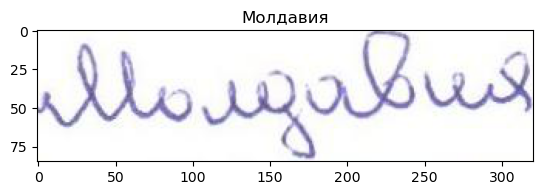

In [17]:
sample = train_labels_df.sample(1)
# draw_image(
#     image_path = os.path.join(images_test_dir, random.choice(os.listdir(images_test_dir))),
# )

draw_image(
    image_path = os.path.join(images_train_dir, sample.Id.item()),
    label = sample.Expected.item()
)

In [18]:
alphabet = ''.join(alphabet_chars)
alphabet

'@vT>WЮjИ5х`bРЕsлNЯ2‐кnHFйФф”Qьіэ,Щ}qG￥-1ыЁБСeRo%З:K\'#НДПшa{&ЙщЛU6’бКнВ9DmгzЭТr–Od„ОciLIy»MЦwя XеS$p=0)hпё|JPtx"_~;чЫм<А/“*Yс[·€ц.E(3!…иVт：оЪМlu＃Ж®gдB№8AЬюГЧ+—«зау7ХвCШжУfр]4?ІkZъ'

In [19]:
alphabet = 'АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯяabcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 ' + string.punctuation

In [20]:
train_config = train_labels_df.apply(lambda item: {'file' : os.path.join(images_train_dir, item.Id),
                                                   'text' : item.Expected}, axis=1).tolist()

In [66]:
test_config = [{'file' : os.path.join(images_test_dir, file_name), 'text' : file_name} for file_name in os.listdir(images_test_dir)]

In [22]:
class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, config, alphabet, transforms=None):
        """Constructor for class.

        Args:
            - config: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.config = config
        self.alphabet = alphabet
        self.image_names, self.texts = self._parse_root_()
        self.transforms = transforms

    def _parse_root_(self):
        image_names, texts = [], []
        for item in self.config:
            image_name = item["file"]
            text = item['text']
            texts.append(text)
            image_names.append(image_name)
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        image = cv2.imread(self.image_names[item]).astype(np.float32) / 255.
        text = self.texts[item]
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        output = dict(image=image, seq=seq, seq_len=seq_len, text=text)
        if self.transforms is not None:
            output = self.transforms(output)

        # output = np.clip(output, 0, 1)
        return output

    def text_to_seq(self, text):
        """Encode text to sequence of integers.

        Args:
            - String of text.

        Returns:
            List of integers where each number is index of corresponding characted in alphabet + 1.
        """

        seq = [self.alphabet.find(c) + 1 for c in text]

        return seq

In [23]:
class Resize(object):

    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, item):
        """Apply resizing.

        Args:
            - item: Dict with keys "image", "seq", "seq_len", "text".

        Returns:
            Dict with image resized to self.size.
        """

        interpolation = cv2.INTER_AREA if self.size[0] < item["image"].shape[1] else cv2.INTER_LINEAR
        item["image"] = np.flip(cv2.resize(item["image"], self.size, interpolation=interpolation), 2)
        item["image"] = np.clip(item["image"], 0, 1)

        return item

In [24]:
transforms = Resize(size=(320, 64))
dataset = RecognitionDataset(train_config, alphabet=alphabet, transforms=transforms)

dict_keys(['image', 'seq', 'seq_len', 'text'])
Image shape: (64, 320, 3)
Seq: [46, 6, 12, 38, 12, 30, 20, 64] Seq_len: 8
Text: цветения


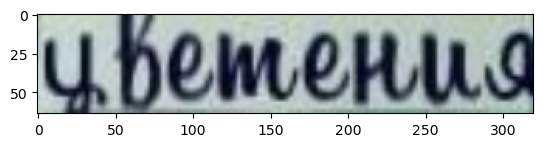

In [28]:
x = dataset[np.random.randint(0, len(dataset))]
print(x.keys())

print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()

In [29]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.

    Args:
        - batch: List of dataset __getitem__ return values (dicts).

    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [30]:
xs = [dataset[i] for i in range(4)]
batch = collate_fn(xs)
print(batch.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


In [31]:
print("Image:", batch["image"].size())
print("Seq:", batch["seq"].size())
print("Seq:", batch["seq"])
print("Seq_len:", batch["seq_len"])
print("Text:", batch["text"])

Image: torch.Size([4, 3, 64, 320])
Seq: torch.Size([25])
Seq: tensor([  1,  38,  56,   0,   2,  40,  38,   0,   2,  30,  18,  44,  32,  10,
         64,  38,  32,  52,  40,  52,  12,  30,  20,  22, 139],
       dtype=torch.int32)
Seq_len: tensor([6, 5, 5, 9], dtype=torch.int32)
Text: ['Атырау', 'транз', 'ходят', 'ощущений,']


In [32]:
class FeatureExtractor(Module):

    def __init__(self, input_size=(64, 320), output_len=40):
        super(FeatureExtractor, self).__init__()

        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = Sequential(*list(resnet.children())[:-2])

        self.pool = AvgPool2d(kernel_size=(h // 32, 1))
        self.proj = Conv2d(w // 32, output_len, kernel_size=1)

        self.num_output_features = self.cnn[-1][-1].bn2.num_features

    def apply_projection(self, x):
        """Use convolution to increase width of a features.

        Args:
            - x: Tensor of features (shaped B x C x H x W).

        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()

        return x

    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)

        # Pool to make height == 1
        features = self.pool(features)

        # Apply projection to increase width
        features = self.apply_projection(features)

        return features

In [33]:
class SequencePredictor(Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()

        self.num_classes = num_classes
        self.rnn = GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)

        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = Linear(in_features=fc_in,
                         out_features=num_classes)

    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.

        Args:
            - batch_size: Int size of batch

        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1

        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)

        return h

    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.

        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).

        Returns:
            New tensor shaped (W x B x H).
        """

        x = x.squeeze(1)
        x = x.permute(2, 0, 1)

        return x

    def forward(self, x):
        x = self._reshape_features(x)

        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)

        x = self.fc(x)
        return x

In [34]:
class CRNN(Module):

    def __init__(self, alphabet=alphabet,
                 cnn_input_size=(64, 320), cnn_output_len=80,
                 rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.3, rnn_bidirectional=False):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(input_size=cnn_input_size, output_len=cnn_output_len)
        self.sequence_predictor = SequencePredictor(input_size=self.features_extractor.num_output_features,
                                                    hidden_size=rnn_hidden_size, num_layers=rnn_num_layers,
                                                    num_classes=len(alphabet)+1, dropout=rnn_dropout,
                                                    bidirectional=rnn_bidirectional)

    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [36]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

### Baseline Model training

In [47]:
crnn = CRNN()

In [48]:
num_epochs = 50
batch_size = 256
num_workers = 2
train_frac = 0.95

In [49]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
crnn.to(device)

CRNN(
  (features_extractor): FeatureExtractor(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(

In [50]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)

In [67]:
np.random.shuffle(train_config)
train_size = int(len(train_config) * train_frac)
config_train = train_config[:train_size]
config_val = train_config[train_size:]
config_test = test_config

train_dataset = RecognitionDataset(config_train, alphabet=alphabet, transforms=Resize())
val_dataset = RecognitionDataset(config_val, alphabet=alphabet, transforms=Resize())
test_dataset = RecognitionDataset(config_test, alphabet=alphabet, transforms=Resize())

In [68]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True,
                              drop_last=True, collate_fn=collate_fn)

val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True,
                            drop_last=False, collate_fn=collate_fn)

test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True,
                             drop_last=False, collate_fn=collate_fn)

In [54]:
best_metric = 10**9

for i, epoch in enumerate(range(num_epochs)):
    crnn.train()

    epoch_losses = []

    for j, b in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
        images = b["image"].to(device)
        seqs_gt = b["seq"]
        seq_lens_gt = b["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                        targets=seqs_gt,  # N, S or sum(target_lengths)
                        input_lengths=seq_lens_pred,  # N
                        target_lengths=seq_lens_gt)  # N

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(crnn.parameters(), 1.0)

        optimizer.step()

        epoch_losses.append(loss.item())

    print(f'Epoch {i+1} loss: {np.mean(epoch_losses)}')

    # валидация (левинштейн)
    crnn.eval()
    with torch.no_grad():
        levenshtein_metrics = []

        for j, b in enumerate(tqdm.tqdm(val_dataloader, total=len(val_dataloader))):
            images = b["image"].to(device)

            seqs_pred = crnn(images).cpu()
            predicted_texts = decode(seqs_pred, alphabet)
            gt_texts = b['text']

            k = len(gt_texts)
            for ex_ind in range(k):
                  levenshtein_metrics.append(
                      edit_distance(predicted_texts[ex_ind], gt_texts[ex_ind])
                  )

        levenshtein_val = np.mean(levenshtein_metrics)

        print(f'Validation on {i+1} epoch levenstein metric: {levenshtein_val:.2f}')
        
        if levenshtein_val < best_metric:
            best_metric = levenshtein_val            
            torch.save(crnn.state_dict(), f'models/rcnn_ep_{i+1}.pth')

100%|██████████| 1020/1020 [07:33<00:00,  2.25it/s]


Epoch 1 loss: 4.746840764260759


100%|██████████| 54/54 [00:15<00:00,  3.46it/s]


Validation on 1 epoch levenstein metric: 5.79


100%|██████████| 1020/1020 [07:34<00:00,  2.24it/s]


Epoch 2 loss: 2.4526654921325983


100%|██████████| 54/54 [00:14<00:00,  3.63it/s]


Validation on 2 epoch levenstein metric: 3.96


100%|██████████| 1020/1020 [07:34<00:00,  2.24it/s]


Epoch 3 loss: 1.5905606698756125


100%|██████████| 54/54 [00:14<00:00,  3.61it/s]


Validation on 3 epoch levenstein metric: 3.16


100%|██████████| 1020/1020 [07:34<00:00,  2.24it/s]


Epoch 4 loss: 1.1994053263874616


100%|██████████| 54/54 [00:14<00:00,  3.60it/s]


Validation on 4 epoch levenstein metric: 2.93


100%|██████████| 1020/1020 [07:31<00:00,  2.26it/s]


Epoch 5 loss: 0.9886113652995988


100%|██████████| 54/54 [00:14<00:00,  3.68it/s]


Validation on 5 epoch levenstein metric: 2.66


100%|██████████| 1020/1020 [07:31<00:00,  2.26it/s]


Epoch 6 loss: 0.8528389266308616


100%|██████████| 54/54 [00:14<00:00,  3.81it/s]


Validation on 6 epoch levenstein metric: 2.53


100%|██████████| 1020/1020 [07:29<00:00,  2.27it/s]


Epoch 7 loss: 0.7557082918636939


100%|██████████| 54/54 [00:14<00:00,  3.73it/s]


Validation on 7 epoch levenstein metric: 2.44


100%|██████████| 1020/1020 [07:30<00:00,  2.26it/s]


Epoch 8 loss: 0.68179059896399


100%|██████████| 54/54 [00:14<00:00,  3.77it/s]


Validation on 8 epoch levenstein metric: 2.39


100%|██████████| 1020/1020 [07:30<00:00,  2.26it/s]


Epoch 9 loss: 0.624250297657415


100%|██████████| 54/54 [00:14<00:00,  3.74it/s]


Validation on 9 epoch levenstein metric: 2.33


100%|██████████| 1020/1020 [07:30<00:00,  2.27it/s]


Epoch 10 loss: 0.5769745181004207


100%|██████████| 54/54 [00:13<00:00,  3.87it/s]


Validation on 10 epoch levenstein metric: 2.32


100%|██████████| 1020/1020 [07:30<00:00,  2.26it/s]


Epoch 11 loss: 0.5420021516435286


100%|██████████| 54/54 [00:14<00:00,  3.83it/s]


Validation on 11 epoch levenstein metric: 2.31


100%|██████████| 1020/1020 [07:31<00:00,  2.26it/s]


Epoch 12 loss: 0.5118172167709061


100%|██████████| 54/54 [00:14<00:00,  3.81it/s]


Validation on 12 epoch levenstein metric: 2.27


100%|██████████| 1020/1020 [07:31<00:00,  2.26it/s]


Epoch 13 loss: 0.4885930773528183


100%|██████████| 54/54 [00:14<00:00,  3.78it/s]


Validation on 13 epoch levenstein metric: 2.28


100%|██████████| 1020/1020 [07:31<00:00,  2.26it/s]


Epoch 14 loss: 0.46738790174325306


100%|██████████| 54/54 [00:14<00:00,  3.75it/s]


Validation on 14 epoch levenstein metric: 2.23


100%|██████████| 1020/1020 [07:32<00:00,  2.26it/s]


Epoch 15 loss: 0.44689748228765


100%|██████████| 54/54 [00:14<00:00,  3.80it/s]


Validation on 15 epoch levenstein metric: 2.23


100%|██████████| 1020/1020 [07:33<00:00,  2.25it/s]


Epoch 16 loss: 0.4324081769176558


100%|██████████| 54/54 [00:14<00:00,  3.81it/s]


Validation on 16 epoch levenstein metric: 2.20


100%|██████████| 1020/1020 [07:31<00:00,  2.26it/s]


Epoch 17 loss: 0.4193931458189207


100%|██████████| 54/54 [00:14<00:00,  3.84it/s]


Validation on 17 epoch levenstein metric: 2.23


100%|██████████| 1020/1020 [07:32<00:00,  2.26it/s]


Epoch 18 loss: 0.40528423711657524


100%|██████████| 54/54 [00:14<00:00,  3.66it/s]


Validation on 18 epoch levenstein metric: 2.20


100%|██████████| 1020/1020 [07:29<00:00,  2.27it/s]


Epoch 19 loss: 0.3964832940376272


100%|██████████| 54/54 [00:14<00:00,  3.79it/s]


Validation on 19 epoch levenstein metric: 2.21


100%|██████████| 1020/1020 [07:30<00:00,  2.26it/s]


Epoch 20 loss: 0.3864135374917704


100%|██████████| 54/54 [00:14<00:00,  3.75it/s]


Validation on 20 epoch levenstein metric: 2.18


100%|██████████| 1020/1020 [07:30<00:00,  2.27it/s]


Epoch 21 loss: 0.37629213876401385


100%|██████████| 54/54 [00:14<00:00,  3.73it/s]


Validation on 21 epoch levenstein metric: 2.16


100%|██████████| 1020/1020 [07:29<00:00,  2.27it/s]


Epoch 22 loss: 0.37153086612621944


100%|██████████| 54/54 [00:14<00:00,  3.75it/s]


Validation on 22 epoch levenstein metric: 2.16


100%|██████████| 1020/1020 [07:32<00:00,  2.25it/s]


Epoch 23 loss: 0.3622529442257741


100%|██████████| 54/54 [00:14<00:00,  3.80it/s]


Validation on 23 epoch levenstein metric: 2.18


100%|██████████| 1020/1020 [07:32<00:00,  2.26it/s]


Epoch 24 loss: 0.356669465145644


100%|██████████| 54/54 [00:14<00:00,  3.83it/s]


Validation on 24 epoch levenstein metric: 2.18


100%|██████████| 1020/1020 [07:32<00:00,  2.25it/s]


Epoch 25 loss: 0.34842342866548137


100%|██████████| 54/54 [00:14<00:00,  3.83it/s]


Validation on 25 epoch levenstein metric: 2.20


100%|██████████| 1020/1020 [07:32<00:00,  2.26it/s]


Epoch 26 loss: 0.3445486616124125


100%|██████████| 54/54 [00:14<00:00,  3.66it/s]


Validation on 26 epoch levenstein metric: 2.12


100%|██████████| 1020/1020 [07:32<00:00,  2.25it/s]


Epoch 27 loss: 0.3387060950199763


100%|██████████| 54/54 [00:14<00:00,  3.74it/s]


Validation on 27 epoch levenstein metric: 2.12


100%|██████████| 1020/1020 [07:33<00:00,  2.25it/s]


Epoch 28 loss: 0.33283198582483275


100%|██████████| 54/54 [00:14<00:00,  3.82it/s]


Validation on 28 epoch levenstein metric: 2.15


100%|██████████| 1020/1020 [07:31<00:00,  2.26it/s]


Epoch 29 loss: 0.32975792065262793


100%|██████████| 54/54 [00:14<00:00,  3.77it/s]


Validation on 29 epoch levenstein metric: 2.15


100%|██████████| 1020/1020 [07:31<00:00,  2.26it/s]


Epoch 30 loss: 0.3253400039146928


100%|██████████| 54/54 [00:14<00:00,  3.71it/s]


Validation on 30 epoch levenstein metric: 2.11


100%|██████████| 1020/1020 [07:31<00:00,  2.26it/s]


Epoch 31 loss: 0.3198497807132263


100%|██████████| 54/54 [00:14<00:00,  3.79it/s]


Validation on 31 epoch levenstein metric: 2.09


100%|██████████| 1020/1020 [07:32<00:00,  2.26it/s]


Epoch 32 loss: 0.3142635542388056


100%|██████████| 54/54 [00:14<00:00,  3.81it/s]


Validation on 32 epoch levenstein metric: 2.09


100%|██████████| 1020/1020 [07:29<00:00,  2.27it/s]


Epoch 33 loss: 0.3103775527328253


100%|██████████| 54/54 [00:14<00:00,  3.81it/s]


Validation on 33 epoch levenstein metric: 2.10


100%|██████████| 1020/1020 [07:28<00:00,  2.27it/s]


Epoch 34 loss: 0.30584961965716645


100%|██████████| 54/54 [00:13<00:00,  3.87it/s]


Validation on 34 epoch levenstein metric: 2.12


100%|██████████| 1020/1020 [07:29<00:00,  2.27it/s]


Epoch 35 loss: 0.30351329271626826


100%|██████████| 54/54 [00:14<00:00,  3.80it/s]


Validation on 35 epoch levenstein metric: 2.07


100%|██████████| 1020/1020 [07:28<00:00,  2.27it/s]


Epoch 36 loss: 0.29994550553314825


100%|██████████| 54/54 [00:14<00:00,  3.82it/s]


Validation on 36 epoch levenstein metric: 2.07


100%|██████████| 1020/1020 [07:27<00:00,  2.28it/s]


Epoch 37 loss: 0.29688720044625155


100%|██████████| 54/54 [00:14<00:00,  3.64it/s]


Validation on 37 epoch levenstein metric: 2.10


100%|██████████| 1020/1020 [07:27<00:00,  2.28it/s]


Epoch 38 loss: 0.29473288691803523


100%|██████████| 54/54 [00:14<00:00,  3.75it/s]


Validation on 38 epoch levenstein metric: 2.09


100%|██████████| 1020/1020 [07:27<00:00,  2.28it/s]


Epoch 39 loss: 0.2931129686863107


100%|██████████| 54/54 [00:14<00:00,  3.84it/s]


Validation on 39 epoch levenstein metric: 2.07


100%|██████████| 1020/1020 [07:27<00:00,  2.28it/s]


Epoch 40 loss: 0.28797676276926903


100%|██████████| 54/54 [00:14<00:00,  3.63it/s]


Validation on 40 epoch levenstein metric: 2.08


100%|██████████| 1020/1020 [07:28<00:00,  2.27it/s]


Epoch 41 loss: 0.28609583930788085


100%|██████████| 54/54 [00:14<00:00,  3.78it/s]


Validation on 41 epoch levenstein metric: 2.07


100%|██████████| 1020/1020 [07:30<00:00,  2.26it/s]


Epoch 42 loss: 0.2848491794192323


100%|██████████| 54/54 [00:14<00:00,  3.78it/s]


Validation on 42 epoch levenstein metric: 2.10


100%|██████████| 1020/1020 [07:30<00:00,  2.26it/s]


Epoch 43 loss: 0.28210947787590035


100%|██████████| 54/54 [00:14<00:00,  3.76it/s]


Validation on 43 epoch levenstein metric: 2.07


100%|██████████| 1020/1020 [07:29<00:00,  2.27it/s]


Epoch 44 loss: 0.27722741862320727


100%|██████████| 54/54 [00:14<00:00,  3.78it/s]


Validation on 44 epoch levenstein metric: 2.08


100%|██████████| 1020/1020 [07:26<00:00,  2.29it/s]


Epoch 45 loss: 0.27928861077034883


100%|██████████| 54/54 [00:14<00:00,  3.78it/s]


Validation on 45 epoch levenstein metric: 2.06


100%|██████████| 1020/1020 [07:27<00:00,  2.28it/s]


Epoch 46 loss: 0.27443406525634084


100%|██████████| 54/54 [00:14<00:00,  3.83it/s]


Validation on 46 epoch levenstein metric: 2.03


100%|██████████| 1020/1020 [07:27<00:00,  2.28it/s]


Epoch 47 loss: 0.2726369117514468


100%|██████████| 54/54 [00:14<00:00,  3.71it/s]


Validation on 47 epoch levenstein metric: 2.06


100%|██████████| 1020/1020 [07:28<00:00,  2.28it/s]


Epoch 48 loss: 0.2724884778370752


100%|██████████| 54/54 [00:14<00:00,  3.71it/s]


Validation on 48 epoch levenstein metric: 2.04


 10%|▉         | 98/1020 [00:43<06:53,  2.23it/s]


KeyboardInterrupt: 

In [99]:
best_epoch = 10
best_model_path = f'models/rcnn_ep_{best_epoch}.pth'
model = CRNN()
model.load_state_dict(torch.load(best_model_path))
model.eval()

CRNN(
  (features_extractor): FeatureExtractor(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(

In [94]:
!ls

01-pytorch-gpu.ipynb			   README.md
02-pytorch-gpu-dask-multiple-models.ipynb  sample_submission.csv
03-pytorch-gpu-dask-single-model.ipynb	   test
images					   train
models					   train_labels.csv
OCR_kaggle_contents.ipynb		   vk-made-ocr.zip
predictions


In [95]:
ss = pd.read_csv('sample_submission.csv')

In [59]:
ss.head()

Id   Predicted
0  1.jpg      vrxqqj
1  2.jpg    hcwqjoop
2  3.jpg      twpsjl
3  4.jpg   qudzdtxdd
4  5.jpg  oipipqztjj

In [100]:
predicted_items = []

for j, b in enumerate(tqdm.tqdm(test_dataloader, total=len(test_dataloader))):
        images = b["image"].to(device)
        file_names = b["text"]
        seqs_pred = crnn(images).cpu()
        predicted_texts = decode(seqs_pred, alphabet)
        
        predicted_items.extend(
            list(zip(file_names, predicted_texts))
        )

100%|██████████| 208/208 [00:51<00:00,  4.07it/s]


In [101]:
prediction_df = pd.DataFrame(predicted_items, columns=['Id', 'Predicted'])
prediction_df['index'] = prediction_df.Id.apply(lambda x: int(x.split('.')[0]))
prediction_df = prediction_df.sort_values(by = 'index')[['Id', 'Predicted']]
prediction_df.head()

Id     Predicted
38144  1.jpg           оу,
21547  2.jpg           I33
5221   3.jpg  LASHANG SANK
7801   4.jpg     Mokelumne
34915  5.jpg           BAO

In [87]:
!mkdir predictions

In [102]:
prediction_df.to_csv(f'predictions/prediction_{best_epoch}.csv', index=None, header=True)

In [91]:
!pwd

/home/jovyan/examples/examples/pytorch


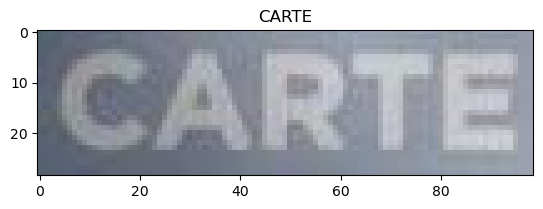

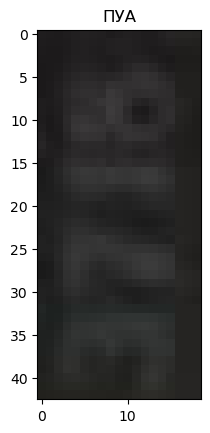

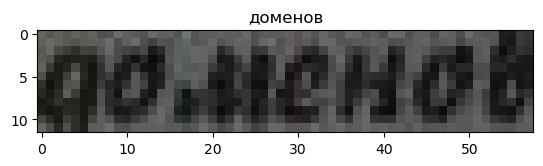

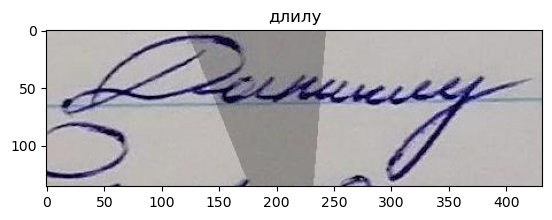

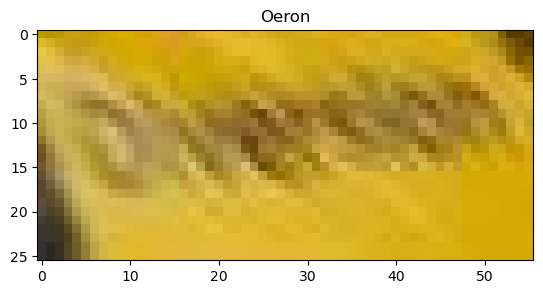

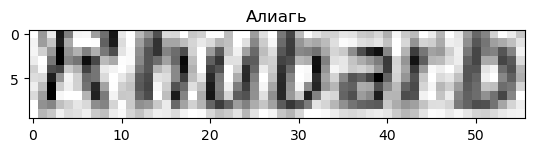

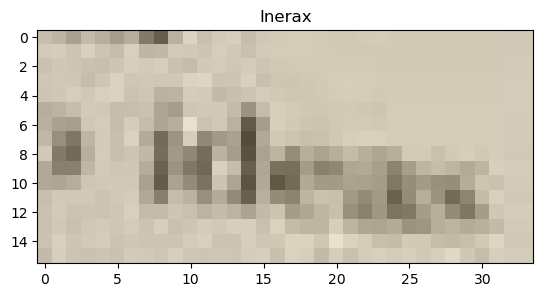

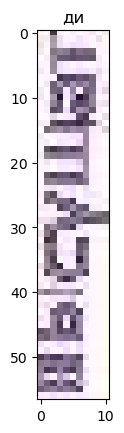

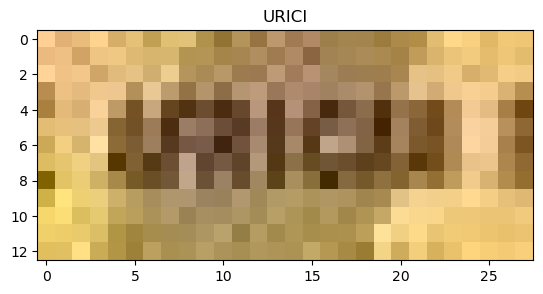

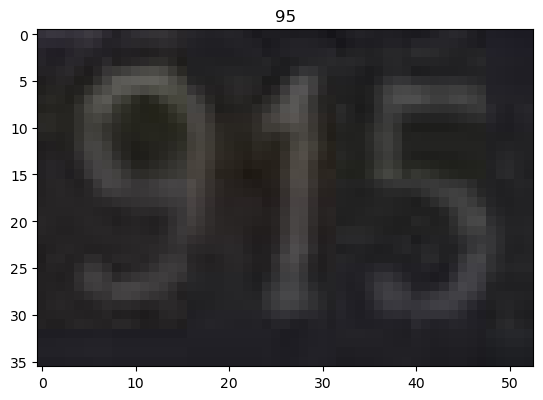

In [107]:
for i in range(10):
    sample = prediction_df.sample(1)

    draw_image(
        image_path = os.path.join(images_test_dir, sample.Id.item()),
        label = sample.Predicted.item()
    )